# Contenidos
* [1. Programación probabilística](#1.-Programación-probabilística)
	* [1.1 PyMC3](#1.1-PyMC3)
	* [1.2 Métodos de muestreo (_samplers_)](#1.2-Métodos-de-muestreo-%28_samplers_%29)
		* [1.2.1 Markov Chain Monte Carlo.](#1.2.1-Markov-Chain-Monte-Carlo.)
		* [1.2.2 Metropolis-Hastings](#1.2.2-Metropolis-Hastings)
		* [1.2.3 Monte Carlo Hamiltoniano y NUTS](#1.2.3-Monte-Carlo-Hamiltoniano-y-NUTS)
	* [1.3 El problema de la moneda revisitado!](#1.3-El-problema-de-la-moneda-revisitado!)
		* [1.3.1 Creación del modelo](#1.3.1-Creación-del-modelo)
		* [1.3.2 Inferencia](#1.3.2-Inferencia)
		* [1.3.3 Diagnóstico de los resultados](#1.3.3-Diagnóstico-de-los-resultados)
			* [1.3.3.1 Diagnóstico de la convergencia](#1.3.3.1-Diagnóstico-de-la-convergencia)
			* [1.3.3.2 Autocorrelación](#1.3.3.2-Autocorrelación)
	* [1.4 Para seguir leyendo](#1.4-Para-seguir-leyendo)


In [ ]:
%matplotlib notebook
import pymc3 as pm  # asi importamos PyMC3!
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from plot_post import plot_post

# 1. Programación probabilística

Como explicamos en el capítulo anterior, la estadística Bayesiana es conceptualmente simple. Un modelo Bayesiano/probabilístico se construye y se resuelve según el siguiente esquema general. Los datos $D$ son fijos (no podemos cambiar lo que hemos medido) y los valores  de los parámetros $\theta$ se hacen variar. La incertidumbre en los parámetros y la relación entre datos y parámetros $p(D|\theta)$ se representan usando distribuciones de probabilidad. Luego, el teorema de Bayes es usado para transformar la distribución _a priori_ $p(\theta)$ (lo que sabemos de un problema antes de observar los datos), en la distribución _a posteriori_ $p(\theta|D)$ (lo que aprendemos una vez observados los datos). La principal dificultad técnica en estadística Bayesiana recide en que los modelos probabilísticos suelen ser analíticamente intratables. A fin de poder resolverlos se recurre a métodos numéricos que pueden ser considerados como _motores universales de inferencia_ (cuyo funcionamiento será explicado más adelante). El hecho que tales motores sean posibles ha motivado el desarrollo de lenguajes de [programación probabilística](http://probabilistic-programming.org/wiki/Home), que permiten una separación clara entre la creación de los modelos y el proceso de inferencia. 

Un lenguaje de programación probabilística es en lineas generales un lenguaje que permite al usuario describir un modelo probabilistico completo escribiendo una pocas lineas de código, las necesarias para describir el modelo, y luego proceder a realizar la inferencia de forma automática. Se espera que la programación probabilistica tenga un gran impacto en estadística, machine learning y otras disciplinas al permitir que científicos construyan modelo complejos en menor tiempo y de forma menos propensa a errores.

Una buena analogía sobre el impacto que un lenguaje de programación puede tener en la ciencia es la introducción del lenguaje de programación Fortran hace más de 6 décadas. Fortran permitió a los científicos, por primera vez, abstraerse de muchos de los detalles computacionales y centrarse en la construcción de métodos numéricos, modelos y simulaciones de una manera más natural. De manera similar, se espera que los programas probabilísticos permitan esconder del usuario detalles de como las probabilidades son manipulados y como se lleva a cabo la inferencia y dejar que los usuarios se centran en la especificación del modelo y en el análisis de los resultados.

## 1.1 PyMC3

PyMC3 es una librería que extiende Python a fin de poder realizar _programación probabilistica_. La primer beta de PyMC3 fue lanzada en Junio de 2015, a pesar de que todavía no ha alcanzado el status de estable, PyMC3 es  lo suficientemente madura para resolver muchos problemas estadísticos.  PyMC3 permite crear modelos probabilísticos usando una sintáxis intuitiva y facil de leer que es muy similar a la sintáxis usada en estadística para describir modelos probabilísticos. 

La mayoría de las funciones de PyMC3 están escritas en Python. Mientras que las partes computacionalmente demandantes están escritas en NumPy y Theano. Theano es una librería numérica que permite escribir código usando tensores (la generalización de los vectores y las matrices a más de 2 dimensiones). Entre las ventajas de Theano encontramos:

* Trabaja junto con NumPy
* Las expresioens escritas con Theano se _traducen_ automáticamente a C y se compilan (aumentando la velocidad del código).
* Theano _sabe_ matemática lo que le permite realizar varias optimizaciones de forma automáticas y calcular gradientes (utiles para los métodos de muestreo como HMC y NUTS)

PyMC3 provee de varios métodos de muestreo (_samplers_), que permiten obtener aproximaciones al _a posteriori_ sin necesidad de restringuir nuestros modelos usando _a prioris_ conjugados. 

Dada la centralidad de los métodos computacionales en el análisis Bayesiano moderno, antes de pasar a ver como usar PyMC3 veremos una rápida descripción de estos métodos de muestreo y algunas de sus propiedades. Una explicación más detallada del funcionamiento de los mismos puede encontrarse en este mismo repositorio en la carpeta _Métodos numéricos_ en la notebook llamada _Métodos_MCMC_ y en las referencias allí indicadas.

## 1.2 Métodos de muestreo (_samplers_)

Existen varios métodos numéricos que pueden funcionar como _motores de inferencia_. La mayoría de ellos estan basados en la idea de que aún cuando no es posible obtener analíticamente la distribución _a posteriori_ suele ser posible tomar muestras de dicha distribución de forma tal de obtener una descripción aproximada, pero confiable. La gran mayoría de los métodos de muestreo (al menos los mas usados) se clasifican dentro de la familia de los _Markov Chain Monte Carlo_ y son lo que brevemente discutiremos a continuación. 

### 1.2.1 Markov Chain Monte Carlo (MCMC).

Todos los métodos MCMC generan muestras del _a posteriori_ por medio de la construcción de una cadena de Markov reversible que tiene como distribución de equilibrio a la distribucion _a posteriori_. 

Probablemente para la mayoría de ustedes la oración previa no dice demasiado, es por ello que iremos desmenuzando la oración a fin de entenderla conceptualmente. Una descripción algo más detallada de estos métodos de muestreo puede encontrarse en la sección *03_métodos_numéricos* de este repositorio 

[Markov Chain Monte Carlo](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) es el nombre de una familia de algoritmos que son extensamente usados en casi todas las ramas de la ciencia. El principal propósito de estos algoritmos es el de obtener muestras de una distribución de probabilidad que es difícil (o imposible) de tratar analíticamente. Esto se logra mediante la construcción de una cadena de Markov que tiene como distribución de equilibrio la distribución que nos interesa. Esto quiere decir que el método garantiza (bajo ciertas condiciones) que mientras más muestras tomemos más nos aproximaremos a la distribución deseada. En este contexto una cadena es un objeto matemático que describe una secuencia de estados y las probabilidades de transición entre dichos estados. Una cadena de Markov es un tipo especial de cadena donde la probabilidad de pasar al próximo estado depende solo del estado actual y no del camino por el cual que se llegó al estado actual.

Un ejemplo clásico de una cadena de Markov es la llamada caminata del borracho. Supongamos que la caminata es unidimensional y que los estados están representados por números enteros. En cada paso el borracho puede o bien moverse a la derecha o bien a la izquierda, con una cierta probabilidad (supongamos que 0.5 a cada lado). En algún momento el borracho se encontraráen la posición -4, por lo que el siguiente estado podría ser o bien -5 o bien -3 (con igual probabilidad), pero independiete de si en el paso anterior el borracho estaba en -5 o en -3. En este ejemplo se vé claramente que la probabilidad de pasar de un estado al otro no depende de los pasos previos del borracho si no solo de su posición actual.

Bien, ahora que sabemos que es una cadena de Markov nos queda ver que es un _Monte Carlo_. El método es un Monte Carlo debido a que usa números aleatorios para obtener resultados. Monte Carlo es el nombre de un casino en Mónaco donde el tío de uno de los creadores del método solía apostar. La idea central de un método de Monte Carlo es que es posible estudiar sistemas complicados muestreándolos en vez de estudiandolos directamente. Por ejemplo si querés saber las probabilidades de ganar en un juego de solitario una opción es tratar de obtener la respuesta de forma analítica (algo un poco complicado dada la naturaleza combinatoria del problema) La otra opción es simplemente jugar tantas partidas de solitario como se pueda y estimar la probabilidad de ganar en el solitario a partir de esas muestras. De hecho es exactamente este problema el que se planteó Stanislaw Ulam (circa 1940) mientras se recuperaba de una cirugía y jugaba al solitario. En esa época las computadoras empezaban a ser una realidad y este y otros investigadores rápidamente vieron el potencial de resolver infinidad de problemas mediante simulaciones simples. La simplicidad de la idea y el aumento incesante del poder de cálculo ha hecho que la aplicación y utilidad de los métodos de Monte Carlo no haya hecho otra cosa que aumentar con el paso de los años.

Dentro de la gran familiar de algoritmos de Markov Chain Monte Carlo el más usado probablemente sea el método de Metropolis-Hastings, además practicamente todos los demás MCMC son considerados variantes de este.

### 1.2.2 Metropolis-Hastings

El algortimo de [Metropolis–Hastings](http://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) permite obtener muestras de cualquier distribución de probabilidad $P(x)$ siempre y cuando sea posible computar un valor proporcional a $P(x)$. Esto es muy útil, por que en muchos problemas incluida la estadística Bayesiana lo que suele ser difícil de computar es el factor de normalización (el denominador en el teorema de Bayes). Para distribuciones simples existen métodos más directos para muestrearlas, pero Metropolis-Hastings al igual que otros métodos MCMC se vuelven cada vez más útiles a medida que las dimensiones aumentan.

El algoritmo de Metropolis-Hastings consiste en los siguientes pasos

1. Elegir un estado inicial $x_i$ (al azar o haciendo uso de información disponible)
2. Elegir un nuevo estado $x_{i+1}$ muestreando a partir de una distribución conocida $Q(x_{i+1}|x_{i})$, o en otras palabras perturbando el estado $x_i$.
3. Computar la probabilidad de aceptar el nuevo estado según la siguiente regla: 

    $$A(x_{i+1} | x_i) = \min\left(1,\frac{P(x_{i+1})}{P(x_{i})}\frac{Q(x_{i} | x_{i+1})}{Q(x_{i+1} | x_{i})}\right)$$

4. Si la probabilidad computada en 3 es más grande que un valor tomado de una distribución uniforme sobre el intervalo [0, 1] aceptar el nuevo estado, caso contrario mantenerse en el estado actual.
5. Iterar desde 2 hasta _convergencia_

Un par de detalles para tener en cuenta

* Si el nuevo estado se propone usando una distribución simétrica, se obtiene:

    $$A(x_{i+1} | x_i) = \min\left(1,\frac{P(x_{i+1})}{P(x_{i})}\right)$$

* Los pasos 3 y 4 implican que siempre aceptamos un paso que nos mueve hacia una zona de mayor probabilidad. Estados menos probables son aceptados probabilísticamente mientrás más grande la diferencia de probabilidades más baja la probabilidad de aceptar el paso.
* Si un estado es aceptado se guarda el valor de ese estado y si es rechazado también, al finalizar tendremos una cadena con varios estados. Si todo _salió bien_ la frecuencia de cada estado en nuestra cadena será (aproximadamente) proporcional a la probabilidad de dicho estado según dicta la distribución de probabilidad que queríamos muestrear (y que no podíamos resolver analíticamente).

### 1.2.3 Monte Carlo Hamiltoniano y NUTS

Existe una garantía teórica de que metrópolis-hastings (como otros MCMC) convergerán a una distribución estacionaria. Sin embargo, en la práctica y para cierto tipo de problemas la convergencia puede ser demasiado lenta. En esos casos se dice que se tiene un _mezclado lento_. Es por ello que varias modificaciones al algortimo de Metropolis-Hastings han sido propuesta (y seguramente otras serán propuestas en el futuro). Una de estas modificaciones se llama Monte Carlo Hamiltoniano, tambien conocido como Monte Carlo Híbrido (HMC). En este método cada estado propuesto es obtenido simulando una partícula que se mueve por una superficie (la distribución de probabilidad que queremos muestrear), la partícula se mueve según su energía potencial y cinética (la suma de ambas es el hamiltoniano). Cada estado propuesto de esta forma es aceptado o rechazado de igual forma que en Metropolis-Hastings. Una de las ventajas de este método es que las nuevas posiciones propuestas tienen una alta probabildiad de ser aceptadas, incluso para posiciones distantes respecto de la posición anterior. El Monte Carlo Hamiltoniano es mucho más cpu-demandante que Metropolis-Hastings; La razón es que es necesario computar el gradiente de la función potencial, al mismo tiempo los metodos HMC resultan en un mejor y más rápido mezclado. Para algunos problemas, especialmente para modelos complejos con mucho parámetros, esta situación de compromiso termina favoreciendo al HMC. 

Un problema con los métodos HMC es que el método necesita de dos parámetros los cuales deben ajustarse empíricamente. Es por ello que se han propuesto métodos para ajustar los paráetros de forma automática. Uno de estos métodos, recientemente propuesto, es llamado _No-U-Turn Sampler_ (NUTS). Este método ha probado ser de mucha utilidad al ofrecer la eficiencia de muestreo del HMC, pero sin la necesidad de ajustar manualmente ningún parámetro.

## 1.3 El problema de la moneda revisitado!

A continuación revisitaremos el problema de la moneda visto en el capítulo anterior, usando esta vez PyMC3 para definir nuestro modelo, hacer inferencia y analizar el _a posterori_. Luego veremos como resolver algunos otros problemas.

A continuación generaremos datos sintéticos, tal como hicimos antes.

In [2]:
np.random.seed(123)
n_experimentos = 4
theta_real = .35  # en una situación real este valor es desconocido
datos = stats.bernoulli.rvs(theta_real, size=n_experimentos)

### 1.3.1 Creación del modelo

Ahora que tenemos nuestros datos es necesario especificar el modelo. Empezamos por el likelihood que viene dado por la distribución de bernoulli (cada uno de los elementos de _datos_ es un experimento de Bernoulli), si en cambio tuviera el número total de "caras" obtenidas en varios experimentos de Bernoulli podríamos modelar el likelihood como una distribución Binomial, recordemos que la distribución Binomial es una generalización de la distribución de Bernoulli y corresponde con la distribución del número de _éxitos_ en una secuencia de $n$ experimentos si/no independientes entre si, donde cada uno de ellos da _éxito_ con probabilidad $\theta$.

Recordemos también que el _a priori_ lo habíamos definido como una distribución beta. En el siguiente ejemplo evaluaremos el caso en que los parámetros de esta distribución son $\alpha=\beta=1$, lo que equivale a una uniforme entre [0,1]. Dejamos como ejercicio el evaluar como cambian los resultados al cambiar estos parámetros y como los resultados se comparan con los obtenidos en el capítulo anterior.

Una forma resumida de expresar este modelo, usando notación habitualmente usada en estadística es la siguiente:

$$\theta \sim \operatorname{Beta}(\alpha=1, \beta=1)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$

Esta notación nos muestra de forma sintética que estamos modelando $\theta$ como si fuese una variable que proviene de una distribución Binomial con parámetros n=1 y p=p (o lo que es equivalente una distribución de Bernoulli). El valor de $p$ es desconocido, pero necesario para resolver el modelo y por ello lo hemos modelado como una distribución $\operatorname{Beta}(\alpha=1, \beta=1)$.

Esto modelo se traduce casi literalmente a PyMC3, veamos:

In [3]:
with pm.Model() as modelo:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=datos)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))

En la primer linea hemos creado un nuevo objeto llamado "modelo". No es necesario saber los detalles de este objeto, basta con saber que es un contenedor para las variables aleatorias y todo lo relacionado con nuestro modelo. PyMC3 usa el statement _with_ indicando que "modelo" es el contexto, basicamente esto permite que PyMC3 sepa que todas las lineas que están dentro del bloque hacen referencia al mismo modelo, sin que tengamos que especificarlo por ejemplo cada vez que creamos una variable.

La segunda linea de código, especifica el _a priori_, como pueden ver la sintaxis sigue de cerca a la notación matemática, la única diferencia es que el primer argumento es siempre una cadena que especifica el nombre de la variable aleatoria (el nombre es usado internamente por Theano/PyMC3), este nombre siempre deberá coincidir con el nombre de la variable de Python a la que se le asigna. De no ser así el código correrá igual, pero puede conducir a errores, por ejemplo luego al analizar el modelo.

En este caso $p$ y $\theta$ son ambas variables aletorias estocásticas, ya que sus valores dependen en parte de los valores de los nodos parentales (p en el caso de \theta y constantes en el caso de $p$) y en parte del azar. Más adelante veremos que es posible además crear variables aletorias deterministas, es decir variables cuyos valores están completamente determinados por los nodos parentales (aun cuando estos nodos seas estocásticos). estas variables de PyMC3 no son números si no distribuciónes (o reglas para generar números a partir de esas distribuciones), con ellas es posible realizar muchas operaciones distintas, sumas, restas divisiones y multiplicaciones, como también operaciones  de algebra lineal como transposiciones, inversas y productos escalares.

En la tercer linea de código se especifica el likelihood, que como verán es similar a la linea anterior con la diferencia que hemos agregado un argumento llamado "observed" la cual le asignamos nuestros datos. Esta es la forma de pasarle a PyMC3 nuestros datos. Los datos pueden ser números, listas de Python, array de NumPy o data_frames de Pandas.

### 1.3.2 Inferencia

Nuestro modelo ya está completamente especificado, lo único que nos resta hacer es obtener el _a posteriori_. Una opción es hacerlo de forma analítica, pero como el título de este capitulo es _programación probabilística_ lo haremos con métodos numéricos. 

En PyMC3 la inferencia se realiza escribiendo las siguientes lineas:

In [4]:
with modelo:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 sec

Primero llamamos al objeto _modelo_, indicando de esta que es sobre ese objeto que queremos realizar la inferencia. En la segunda linea se introduce el metodo *find_MAP*, MAP es _Máximo A Posteriori_ (por su sigla en inglés y castellano). El MAP es la moda del _a posteriori_ y puede ser encontrado usando métodos de optimización numérica. Si bien en algunos casos el MAP puede ser de utilidad en general no es lo que nos interesa, ya que el MAP puede tener algunos problemas: 

* Solo obtenemos una estimación puntual, no hay medida de la incerteza.
* La moda puede no ser representativa de la distribución
* La gran mayoría de los métodos para encontrar el MAP, solo encuentran mínimos locales. Es decir no son útiles en distribuciones multimodales.

En este curso solo usaremos el MAP como punto inicial de muestro muestreo.

En la tercer linea hemos definido que vamos a realizar el muestreo del _a posteriori_ usando Metropolis-Hastings (llamado simplemente Metropolis). Como veremos más adelante no siempre deberemos elegir un solo método de muestreo, si no que es posible combinarlos (asignado distintos métodos a distintas variables).

La última linea es la que ejecuta todo el código, el primer argumento es la cantidad de pasos y _step_ y _start_, son el método de muestreo y el punto desde donde iniciar el muestreo, respectivamente. _Start_ es opcional.

### 1.3.3 Diagnóstico de los resultados

Una vez concluido el muestreo, que en este caso demora apenas unos segundos (si todo salió bien), PyMC3 provee de varias herramientas para ayudar en el análisis de los resultados. Antes de pasar a sacar conclusiones derivadas del _a posteriori_ deberemos evaluar si la cadena obtenida, usando los métodos MCMC (u otros métodos numéricos) es representativa del _a posteriori_. La teoría detrás de estos métodos garantiza que eso sucede si la cantidad de pasos es infinita. En la práctica, necesitamos determinar el número mínimo de pasos que garantiza una buena muestra, lamentablemente no existen reglas universales para este fin, por lo tanto siempre deberemos hacer un diagnóstico de la convergencia antes de empezar a sacar conclusiones derivadas del _a posteriori_.

Generalmente lo primero que uno quiere hacer es ver _que pinta_ tienen los resultados, para ello podemos usar la función _traceplot_. Traceplot nos muestra dos gráficos por cada parámetro que hayamos muestreado. A la izquierda se gráfica un KDE del _a posteriori_ para cada _variable aleatoria estocástica_ en el modelo (en este caso solo $\theta$). A la derecha se grafican los valores individuales de la cadena de Markov en forma secuencial.

<IPython.core.display.Javascript object>


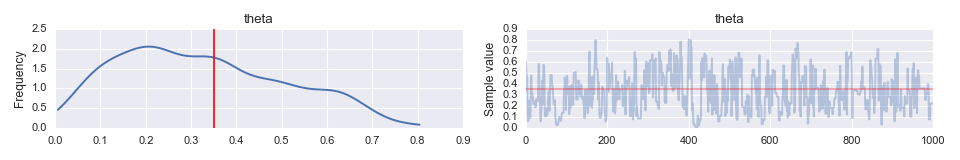

In [5]:
pm.traceplot(trace, vars=['theta'], lines={'theta':theta_real});

#### 1.3.3.1 Diagnóstico de la convergencia

Alcanzar la distribución de equilibrio suele demorar varias iteraciones, exactamente cuantas dependerá de la complejidad del modelo, de cuan correlacionadas están las variables a muestrear y del método usado para muestrear. Dado que solo nos son útiles las muestras provenientes de la distribucion de equilibrio, en general suele ser útil eliminar los primeros elementos de una cadena, lo que se conoce como _burnin_. 

Una forma simple de diagnosticar, _a ojo_, la convergencia y determinar la cantidad de _burnin_ es observar las gráficas generada por _traceplot_ para distintas simulaciones. PyMC permite correr varias siulaciones en simultaneo y analisarlas juntas en un mismo _trace plot_. Para ello podemos la funcion _sample_ tiene el argumento _njobs_ el cual corresponde al número de simulaciones que queremos realizar.

In [6]:
with modelo:
    start = pm.find_MAP()
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step, start=start, njobs=4)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.3 sec

<IPython.core.display.Javascript object>


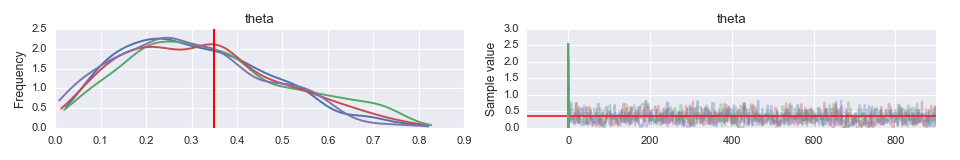

In [7]:
burnin = 100
pm.traceplot(multi_trace[burnin:], vars=['theta'], lines={'theta':theta_real});

Otra prueba es tomar, para una misma cadena sub-muestras de cierta cantidad de pasos, si hay convergencia las submuestras se parecerán entre si y se parecerán a la muestra completa.

En el modelo anterior pareciera que no hemos alcanzado convergencia. Para hacerlo mas explícito grafiquemos 4 ventanas.

In [8]:
def conv_test(muestra, blocks=4):
    idx = [int(x) for x in np.linspace(0, len(muestra), blocks+1)]
    for i in range(blocks):
        sns.kdeplot(muestra[idx[i]:idx[i+1]])

conv_test(trace['theta'][burnin:])

Este es un buen momento para volver atrás y ver como cambian estas pruebas al cambiar la cantidad de iteraciones y la cantidad de _burnin_.

#### 1.3.3.2 Autocorrelación

Otra propiedad que es conveniente evaluar es la autocorrelación de la cadena, es decir la dependencia de un valor en la cadena respecto del anterior (o posterior). Las muestras generadas usando métodos MCMC, especialmente Metropolis-hastings, pueden tener cierto grado de autocorrelación. Medir la autocorrelación suele ser util para dignosticar el correcto muestreo de nuestro modelo, por ello PyMC3 provee de la siguiente función.

<IPython.core.display.Javascript object>


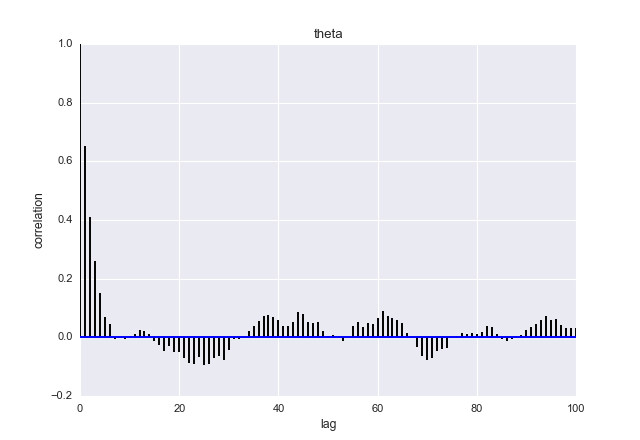

In [9]:
pm.autocorrplot(trace, vars=['theta']);

El gráfico muestra el grado de correlación observado para un punto en cadena de Markov respecto de sucesivos puntos. Si, la autocorrelación es baja y solo se propaga para unos pocos puntos sucesivos (como en el anterior gráfico) entonces basta con hacer _thinning_ de la muestra, es decir tomar puntos de nuestra cadena cada una cierta cantidad de pasos. Si en cambio la correlación es grande y se propaga varias decenas de iteraciones, nos estará indicando que el método de muestreo tiene serios problemas para muestrear adecuadamente. Una solución es probar con otro método de muestreo. Si el problema persiste es probable que debamos introducir modificaciones en nuestro modelo (como veremos en el capítulo X).

<IPython.core.display.Javascript object>


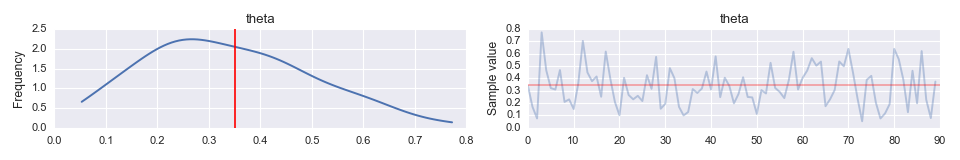

In [10]:
thin = 10
pm.traceplot(trace[burnin::thin], vars=['theta'], lines={'theta':theta_real});

La función _summary_ provista por PyMC3 provee, en formato texto, de una serie de medidas estadísticas que se suelen usar para resumir el _a posteriori_. _MC Error_ es una estimación del error introducido en el muestreo. Para calcularlo se divide a cadena en $n$ bloques y se calcula la media con los valores de cada bloque, a los valores obtenidos $X$ se les calcula el _error estandard de la media_.

$$MC_{error} = \frac{s(X)}{\sqrt{n}} $$

In [11]:
pm.summary(trace[burnin::thin], vars=['theta'])


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.338            0.160            nan              [0.076, 0.639]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.076          0.217          0.316          0.448          0.639



/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [ ]:
## Contando (la distribución de Poisson)

http://sumsar.net/blog/2014/09/bayesian-first-aid-poisson-test/
    
pagina 45 Gelman

## 1.4 Para seguir leyendo

* Más sobre Teorema de Bayes y modelo binomial:
    * Capítulo 1 y 2 [Data Analysis: A Bayesian Tutorial](http://www.amazon.com/Data-Analysis-A-Bayesian-Tutorial/dp/0198568320) de Devinderjit Sivia & John Skilling
    * Capitulo 4 y 5 de Doing Bayesian Data Analysis de Kruschke (1 [edición](http://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0123814855)) y capítulos 5 y 6 (2 [edición](www.amazon.com/gp/product/0124058884))
    * Capitulo 1-4 de [Think Bayesian](http://greenteapress.com/thinkbayes/) de Allen B. Downey 
    * Capitulo 1 y 2 de [Bayesian Data Analysis](www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954) de Andrew Gelman

    
* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)

In [12]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo Ubuntu 15.04 y usando:
Python 3.4.3
IPython 4.0.0
PyMC3 3.0
NumPy 1.10.1
SciPy 0.16.0
Matplotlib 1.4.3
Seaborn 0.6.0

